In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import numpy as np
import pdb

# my code
from distribution import RBMLatentPosterior, MultivariateBernoulliNoise
from latent_nce_optimiser import LatentNCEOptimiser
from latent_variable_model import RestrictedBoltzmannMachine

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

# For reproducibility
rng = rnd.RandomState(1083463236)

# Model definition

In [3]:
n = 10000 # number of datapoints
nz = 1  # number latent samples per datapoint
nu = 1

d = 2  # visible dimension
m = 1  # latent dimension
"""true_W = np.array([[0, 0.1, 0.2],
                  [-1, -0.3, 0.4],
                  [1, -0.5, 0.6], 
                  [0, -0.7, 0.8]])"""

true_W = np.array([[0, 0],
                   [1, -0.5], 
                   [-1, 0.5]])
#theta0 = true_W
theta0 = rnd.uniform(-0.1, 0.1, (d+1, m+1))

In [4]:
true_data_dist = RestrictedBoltzmannMachine(true_W)
X, Z = true_data_dist.sample(n, num_iter=1000)

In [5]:
X_mean = np.mean(X, axis=0)
# X_centred = X - X_mean
# X_cov = (1/n)*np.dot(X_centred.T, X_centred)

In [6]:
model = RestrictedBoltzmannMachine(theta0)

In [7]:
noise = MultivariateBernoulliNoise(X_mean)  # uniform dist over binary vectors i.e p(u) = 2**-d
var_dist = RBMLatentPosterior(theta0)

In [8]:
optimiser = LatentNCEOptimiser(model, noise, var_dist, n, nu=nu, latent_samples_per_datapoint=nz)

# Validation

In [9]:
all_visibles = true_data_dist.get_all_binary_vectors(d)
visible_probs, norm_const = true_data_dist.normalised_and_marginalised_over_z(all_visibles)

In [10]:
print('Sum over all visible probabilities should equal 1. We got: {}'.format(sum(visible_probs)))

Sum over all visible probabilities should equal 1. We got: 1.0


In [11]:
print('-------------------------Visible probability checks--------------------------------------')
for i in range(2**d):
    freq = np.sum(np.product((X == all_visibles[i]), axis=-1))/ len(X)
    print('{}:  Empirical frequency is {}. True frequency is {}'.format(all_visibles[i], 
                                                                         freq, visible_probs[i]))

-------------------------Visible probability checks--------------------------------------
[0 0]:  Empirical frequency is 0.2117. True frequency is 0.2141003675964939
[0 1]:  Empirical frequency is 0.1099. True frequency is 0.10431078039450867
[1 0]:  Empirical frequency is 0.4722. True frequency is 0.4674884844125036
[1 1]:  Empirical frequency is 0.2062. True frequency is 0.2141003675964939


In [12]:
print('normalisation constant is: {}'.format(norm_const))

normalisation constant is: 9.341413200043249


In [13]:
all_hiddens = true_data_dist.get_all_binary_vectors(m)
hidden_probs, norm_const = true_data_dist.normalised_and_marginalised_over_u(all_hiddens)

In [14]:
print('Sum over all hidden probabilities should equal 1. We got: {}'.format(sum(hidden_probs)))

Sum over all hidden probabilities should equal 1. We got: 1.0


In [19]:
var_dist.alpha = true_W.reshape(-1)
Z = var_dist.sample(1000, X)

In [20]:
Z.shape

(1000, 10000, 1)

In [21]:
print('-------------------------Hidden probability checks--------------------------------------')
for i in range(2**m):
    freq = np.mean(np.product((Z == all_hiddens[i]), axis=(-1)))
    print('{}:  Empirical frequency is {}. True frequency is {}'.format(all_hiddens[i], 
                                                                         freq, hidden_probs[i]))

-------------------------Hidden probability checks--------------------------------------
[0]:  Empirical frequency is 0.5443732. True frequency is 0.5444744987414687
[1]:  Empirical frequency is 0.4556268. True frequency is 0.45552550125853125


In [22]:
print('normalisation constant is: {}'.format(norm_const))

normalisation constant is: 9.341413200043249


## Optimisation

         Current function value: 1.567470
         Iterations: 2
         Function evaluations: 79
         Gradient evaluations: 67
         Current function value: 1.516330
         Iterations: 0
         Function evaluations: 110
         Gradient evaluations: 98


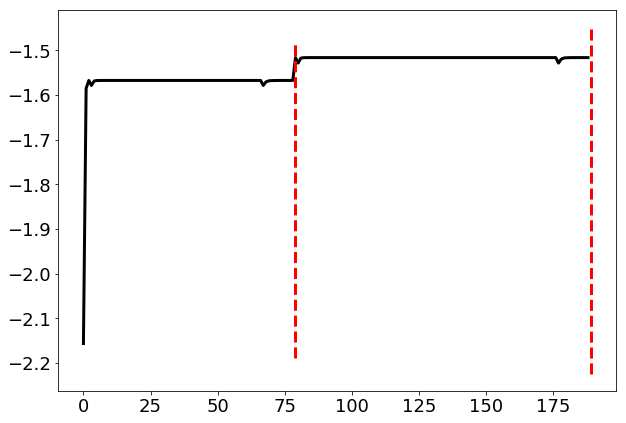

In [12]:
thetas_after_EM_step, J1s, J1_grads = optimiser.fit_using_analytic_q(X, theta0=theta0.reshape(-1), stop_threshold=10**-3)

In [13]:
model.theta.reshape(d+1, m+1)

array([[-1.09015727, -0.48316575],
       [-0.52900072, -0.40841448],
       [-0.05509444, -0.26461797]])

In [14]:
true_W, print('scaling parameter should equal {}'.format(-np.log(norm_const)))

scaling parameter should equal -2.234457547009601


(array([[ 0. ,  0. ],
        [ 1. , -0.5],
        [-1. ,  0.5]]), None)

In [15]:
print('    ---DATA FROM TRUE DISTRIBUTION---         \n')
for i in range(d):
    print('empirical prob of x_{} being 1 is {}.'.format(i, np.mean(X[:, i])))
print('\n')
for i in range(m):
    print('empirical prob of z_{} being 1 is {}.'.format(i, np.mean(Z[:, i])))

    ---DATA FROM TRUE DISTRIBUTION---         

empirical prob of x_0 being 1 is 0.6858.
empirical prob of x_1 being 1 is 0.3202.


empirical prob of z_0 being 1 is 0.4435.


In [16]:
model_X, model_Z = model.sample(n, num_iter=10000)
print('         ---DATA FROM MODEL---         \n')
for i in range(d):
    print('empirical prob of x_{} being 1 is {}.'.format(i, np.mean(model_X[:, i])))
print('\n')
for i in range(m):
    print('empirical prob of z_{} being 1 is {}.'.format(i, np.mean(model_Z[:, i])))

         ---DATA FROM MODEL---         

empirical prob of x_0 being 1 is 0.3446.
empirical prob of x_1 being 1 is 0.4672.


empirical prob of z_0 being 1 is 0.3274.


In [17]:
print('average value of model on true data: {} \n'
'average value of model on model data: {}'.format(
      np.mean(model(X, Z.reshape(1, n, -1))), 
      np.mean(model(model_X, model_Z.reshape(1, n, -1)))))

average value of model on true data: 0.17992333834179686 
average value of model on model data: 0.23595592665761098


In [18]:
print('average value of true dist on true data: {} \n'
'average value of true dist on model data: {}'.format(
      np.mean(true_data_dist(X, Z.reshape(1, n, -1))), 
      np.mean(true_data_dist(model_X, model_Z.reshape(1, n, -1)))))

average value of true dist on true data: 1.5712023418044159 
average value of true dist on model data: 1.0882661974891328


In [19]:
Y = optimiser.Y
model.theta = theta0.reshape(-1)
var_dist.alpha = theta0.reshape(-1)
ZX, ZY = var_dist.sample(nz, X), var_dist.sample(nz, Y)
optimiser.compute_J1(X, ZX, ZY)

-2.1562794712344875